# Klasifikasi Nominal Uang Rupiah dengan CNN

Proyek merupakan bentuk pemenuhan dari Proyek Akhir praktikum Kecerdasan buatan dan bertujuan untuk membangun model Deep Learning menggunakan Convolutional Neural Network yang mampu mengklasifikasikan citra uang rupiah ke dalam 11 kelas nominal berbeda. 

## 1. Import Library dan Setup Environment

Import seluruh library yang diperlukan untuk membangun model. Library-library ini dibagi menjadi beberapa kategori berdasarkan fungsinya:

**Library Core Python:**
- `os` dan `pathlib`: Untuk manipulasi file system dan path management
- `numpy`: Library fundamental untuk komputasi numerik dan array operations
- `pandas`: Untuk manipulasi dan analisis data tabular
- `collections.Counter`: Untuk counting dan statistik data

**Library Visualisasi:**
- `matplotlib`: Library plotting fundamental untuk membuat berbagai jenis grafik
- `seaborn`: Library visualisasi tingkat tinggi yang dibangun di atas matplotlib untuk plot yang lebih estetik

**Library Image Processing:**
- `PIL (Pillow)`: Untuk membaca, memanipulasi, dan menyimpan berbagai format gambar
- `cv2 (OpenCV)`: Library computer vision untuk advanced image processing

**Library Deep Learning (TensorFlow/Keras):**
- `tensorflow` dan `keras`: Framework deep learning untuk membangun dan melatih neural network
- `layers` dan `models`: Untuk konstruksi arsitektur neural network
- `ImageDataGenerator`: Untuk data augmentation dan preprocessing gambar
- `callbacks`: Untuk monitoring dan kontrol training process
- `optimizers`: Algoritma optimisasi (Adam) untuk update weights

**Library Evaluasi Model:**
- `sklearn.metrics`: Untuk menghitung berbagai metrik evaluasi (confusion matrix, classification report)
- `sklearn.utils.class_weight`: Untuk menangani imbalanced dataset

**Reproducibility:**
Random seed di-set untuk memastikan hasil yang konsisten setiap kali training dijalankan.

**Instalasi:**
Jika belum menginstall library yang diperlukan:
```bash
pip install -r lib_requirement.txt
py -m ipykernel install --name=<nama_venv>
```

In [32]:
# import library untuk manipulasi data dan sistem operasi
import os  # untuk operasi sistem operasi dan path
import numpy as np  # untuk array operations dan komputasi numerik
import pandas as pd  # untuk manipulasi data dalam bentuk dataframe
from pathlib import Path  # untuk object-oriented path manipulation
import shutil  # untuk high-level file operations
from collections import Counter  # untuk counting dan statistik data

# import library untuk visualisasi data dan hasil
import matplotlib.pyplot as plt  # untuk membuat plot dan visualisasi
import seaborn as sns  # untuk visualisasi statistik yang lebih estetik

# import library untuk image processing
from PIL import Image  # untuk membaca dan memanipulasi gambar
import cv2  # untuk advanced computer vision operations

# import library tensorflow dan keras untuk deep learning
import tensorflow as tf  # framework deep learning utama
from tensorflow import keras  # API neural networks
from tensorflow.keras import layers, models  # untuk membangun arsitektur model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array  # untuk data augmentation dan preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard  # untuk monitoring training
from tensorflow.keras.optimizers import Adam  # optimizer untuk gradient descent
from tensorflow.keras.utils import plot_model  # untuk visualisasi arsitektur model

# import library untuk evaluasi performa model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # metrik evaluasi klasifikasi
from sklearn.utils.class_weight import compute_class_weight  # untuk handle imbalanced dataset

# set random seed untuk reproducibility hasil training
np.random.seed(42)  # seed untuk numpy random operations
tf.random.set_seed(42)  # seed untuk tensorflow random operations

# konfigurasi style visualisasi untuk consistency
try:
    plt.style.use('seaborn-v0_8-darkgrid')  # try new seaborn style
except:
    plt.style.use('seaborn-darkgrid')  # fallback to old seaborn style
sns.set_palette("husl")  # set color palette seaborn

# print informasi versi dan hardware availability
print(f"tensorflow version: {tf.__version__}")
print(f"gpu available: {tf.config.list_physical_devices('GPU')}")

tensorflow version: 2.10.0
gpu available: []


## 2. Data Collection

Data collection yang baik menentukan kualitas model yang dihasilkan.

**Struktur Dataset:**

Dataset terdiri dari gambar uang rupiah yang dibagi menjadi tiga subset:
- **Training Set**: Digunakan untuk melatih model dan update weights
- **Validation Set**: Digunakan untuk evaluasi model selama training dan hyperparameter tuning
- **Test Set**: Digunakan untuk evaluasi final performa model pada data yang benar-benar unseen

**Kelas yang Tersedia:**

Dataset mencakup 11 kelas nominal uang rupiah Indonesia:
- **Koin** (4 kelas): 100, 200, 500, 1000
- **Kertas** (7 kelas): 1000, 2000, 5000, 10000, 20000, 50000, 100000

In [33]:
# definisi base directory menggunakan pathlib untuk path management yang robust
base_dir = Path(r'C:\Users\Farre\Downloads\rupiah-classification-model\data')  # root directory dataset

# buat path objects untuk setiap split dataset menggunakan operator /
train_dir = base_dir / 'train'  # direktori untuk data training
valid_dir = base_dir / 'valid'  # direktori untuk data validation
test_dir = base_dir / 'test'  # direktori untuk data testing

# definisi nama kelas yang akan diprediksi, diurutkan alfabetis untuk consistency
class_names = sorted([  # sorted memastikan urutan yang konsisten
    'koin_100', 'koin_200', 'koin_500', 'koin_1000',  # 4 kelas koin
    'kertas_1000', 'kertas_2000', 'kertas_5000', 'kertas_10000',  # kelas kertas kecil-menengah
    'kertas_20000', 'kertas_50000', 'kertas_100000'  # kelas kertas besar
])

# print struktur dataset untuk verifikasi dan dokumentasi
print("struktur dataset:")
print(f"direktori base: {base_dir}")
print(f"direktori training: {train_dir}")
print(f"direktori validasi: {valid_dir}")
print(f"direktori testing: {test_dir}")
print(f"\njumlah kelas: {len(class_names)}")
print(f"daftar kelas: {class_names}")

struktur dataset:
direktori base: C:\Users\Farre\Downloads\rupiah-classification-model\data
direktori training: C:\Users\Farre\Downloads\rupiah-classification-model\data\train
direktori validasi: C:\Users\Farre\Downloads\rupiah-classification-model\data\valid
direktori testing: C:\Users\Farre\Downloads\rupiah-classification-model\data\test

jumlah kelas: 11
daftar kelas: ['kertas_1000', 'kertas_10000', 'kertas_100000', 'kertas_2000', 'kertas_20000', 'kertas_5000', 'kertas_50000', 'koin_100', 'koin_1000', 'koin_200', 'koin_500']


In [34]:
# definisi fungsi utility untuk menghitung jumlah gambar per kelas
def count_images_per_class(directory):

    counts = {}  # inisialisasi dictionary kosong untuk menyimpan hasil counting
    
    # iterasi setiap kelas yang telah didefinisikan
    for class_name in class_names:
        class_path = directory / class_name  # construct path ke folder kelas
        
        # cek apakah direktori kelas exists untuk avoid error
        if class_path.exists():
            # glob('*') mengambil semua file dalam direktori, lalu hitung panjangnya
            counts[class_name] = len(list(class_path.glob('*')))
        else:
            # jika direktori tidak ada, set count = 0
            counts[class_name] = 0
    
    return counts  # return dictionary hasil counting

# eksekusi fungsi counting untuk setiap split dataset
train_counts = count_images_per_class(train_dir)  # hitung gambar training
valid_counts = count_images_per_class(valid_dir)  # hitung gambar validation
test_counts = count_images_per_class(test_dir)  # hitung gambar testing

# konversi dictionary menjadi pandas dataframe untuk analisis yang lebih mudah
df_counts = pd.DataFrame({
    'train': train_counts,  # kolom untuk jumlah gambar training
    'valid': valid_counts,  # kolom untuk jumlah gambar validation
    'test': test_counts  # kolom untuk jumlah gambar testing
})

# tambahkan kolom derived untuk analisis lebih lanjut
df_counts['total'] = df_counts.sum(axis=1)  # total gambar per kelas (sum horizontal)
df_counts['train_pct'] = (df_counts['train'] / df_counts['total'] * 100).round(2)  # persentase data training

# print hasil analisis untuk dokumentasi dan verifikasi
print("\njumlah gambar per kelas:")
print(df_counts)
print(f"\ntotal gambar:")
print(f"training: {df_counts['train'].sum()}")
print(f"validasi: {df_counts['valid'].sum()}")
print(f"testing: {df_counts['test'].sum()}")
print(f"total keseluruhan: {df_counts['total'].sum()}")


jumlah gambar per kelas:
               train  valid  test  total  train_pct
kertas_1000      745    154   102   1001      74.43
kertas_10000     753    147   100   1000      75.30
kertas_100000    743    146   111   1000      74.30
kertas_2000      730    163   107   1000      73.00
kertas_20000     776    138    85    999      77.68
kertas_5000      732    160   108   1000      73.20
kertas_50000     760    129   111   1000      76.00
koin_100         926    184    78   1188      77.95
koin_1000        811    180   120   1111      73.00
koin_200         992    188    73   1253      79.17
koin_500        1034    205   115   1354      76.37

total gambar:
training: 9002
validasi: 1794
testing: 1110
total keseluruhan: 11906


In [35]:
# hitung statistik deskriptif untuk distribusi data training
train_mean = df_counts['train'].mean()  # rata-rata jumlah gambar per kelas
train_std = df_counts['train'].std()  # standar deviasi untuk mengukur variabilitas

# print statistik distribusi untuk identifikasi imbalance
print(f"\nstatistik distribusi data training:")
print(f"rata-rata gambar per kelas: {train_mean:.2f}")
print(f"standar deviasi: {train_std:.2f}")
print(f"minimum: {df_counts['train'].min()}")
print(f"maksimum: {df_counts['train'].max()}")

# definisi threshold untuk identifikasi kelas minority
# kelas dengan < 70% rata-rata dianggap imbalanced
threshold = train_mean * 0.7  # 70% dari rata-rata

# filter dataframe untuk mendapatkan kelas-kelas yang imbalanced
imbalanced_classes = df_counts[df_counts['train'] < threshold]

# analisis dan report kelas-kelas minority
print(f"\nkelas dengan data tidak seimbang (< {threshold:.0f} gambar):")
if len(imbalanced_classes) > 0:  # jika ada kelas imbalanced
    # iterasi setiap kelas imbalanced dan hitung deficit
    for idx, row in imbalanced_classes.iterrows():
        deficit = threshold - row['train']  # selisih dari threshold
        print(f"  {idx}: {row['train']} gambar (kurang {deficit:.0f} dari threshold)")
else:
    print("  tidak ada kelas yang sangat tidak seimbang")


statistik distribusi data training:
rata-rata gambar per kelas: 818.36
standar deviasi: 111.40
minimum: 730
maksimum: 1034

kelas dengan data tidak seimbang (< 573 gambar):
  tidak ada kelas yang sangat tidak seimbang


In [36]:
# definisi fungsi untuk analisis properti teknis gambar
def analyze_image_properties(directory, sample_size=50):

    properties = []  # list untuk menyimpan properti semua gambar
    
    # iterasi setiap kelas dalam dataset
    for class_name in class_names:
        class_path = directory / class_name  # construct path ke folder kelas
        
        # skip kelas jika direktorinya tidak ada
        if not class_path.exists():
            continue
        
        # ambil sample gambar dari kelas ini (maksimal sample_size)
        images = list(class_path.glob('*'))[:sample_size]
        
        # analisis setiap gambar dalam sample
        for img_path in images:
            try:
                # buka gambar menggunakan PIL dengan context manager
                with Image.open(img_path) as img:
                    width, height = img.size  # ekstrak dimensi gambar
                    
                    # simpan berbagai properti gambar ke dictionary
                    properties.append({
                        'class': class_name,  # nama kelas gambar
                        'width': width,  # lebar dalam pixel
                        'height': height,  # tinggi dalam pixel
                        'aspect_ratio': width / height,  # rasio aspek (landscape/portrait)
                        'format': img.format,  # format file (JPEG, PNG, etc)
                        'mode': img.mode,  # color mode (RGB, grayscale, etc)
                        'size_kb': os.path.getsize(img_path) / 1024  # ukuran file dalam KB
                    })
            except Exception as e:
                # handle error jika gambar corrupt atau tidak bisa dibaca
                print(f"error membaca {img_path}: {e}")
    
    # konversi list of dictionaries menjadi dataframe untuk analisis
    return pd.DataFrame(properties)

# eksekusi analisis properti pada training set
print("\nmenganalisis properti gambar dari training set...")
df_properties = analyze_image_properties(train_dir, sample_size=50)

# print statistik deskriptif untuk dimensi gambar
print(f"\nstatistik dimensi gambar:")
print(df_properties[['width', 'height', 'aspect_ratio']].describe())

# print distribusi format file gambar
print(f"\nformat gambar:")
print(df_properties['format'].value_counts())

# print distribusi color mode gambar
print(f"\nmode warna:")
print(df_properties['mode'].value_counts())


menganalisis properti gambar dari training set...



statistik dimensi gambar:
             width      height  aspect_ratio
count   550.000000  550.000000    550.000000
mean   1275.890909  717.927273      1.774949
std      68.079476   34.340975      0.046859
min     150.000000  150.000000      1.000000
25%    1280.000000  720.000000      1.777778
50%    1280.000000  720.000000      1.777778
75%    1280.000000  720.000000      1.777778
max    1280.000000  720.000000      1.777778

format gambar:
format
JPEG    550
Name: count, dtype: int64

mode warna:
mode
RGB    550
Name: count, dtype: int64


## 3. Data Analysis & Visualization

Visualisasi untuk memahami karakteristik dataset sebelum memulai training. Bagian ini akan menghasilkan berbagai plot informatif yang membantu dalam:

**Tujuan Visualisasi:**

1. **Mengidentifikasi Class Imbalance**: Mendeteksi ketidakseimbangan jumlah sampel antar kelas yang dapat menyebabkan bias dalam prediksi model
2. **Memvalidasi Data Split**: Memastikan proporsi training/validation/test set sudah sesuai dengan best practice (biasanya 80/10/10 atau 70/15/15)
3. **Inspeksi Visual Sampel**: Melihat contoh gambar dari setiap kelas untuk memahami variasi visual dan kualitas data
4. **Mendeteksi Anomali**: Menemukan gambar yang corrupt, blur, atau tidak sesuai dengan kelas

**Plot yang Dihasilkan:**

1. **Bar Chart Distribusi Training**: Membandingkan jumlah sampel per kelas dengan threshold imbalance
2. **Grouped Bar Chart**: Membandingkan distribusi sampel across train/valid/test untuk setiap kelas
3. **Pie Chart**: Menampilkan proporsi total sampel untuk setiap split dataset
4. **Heatmap**: Visualisasi 2D yang menunjukkan distribusi sampel dengan color coding

**Insight yang Diharapkan:**

- Apakah ada kelas yang terlalu dominan atau terlalu minority
- Kelas mana yang perlu augmentasi lebih agresif
- Kualitas visual dan variasi gambar dalam setiap kelas

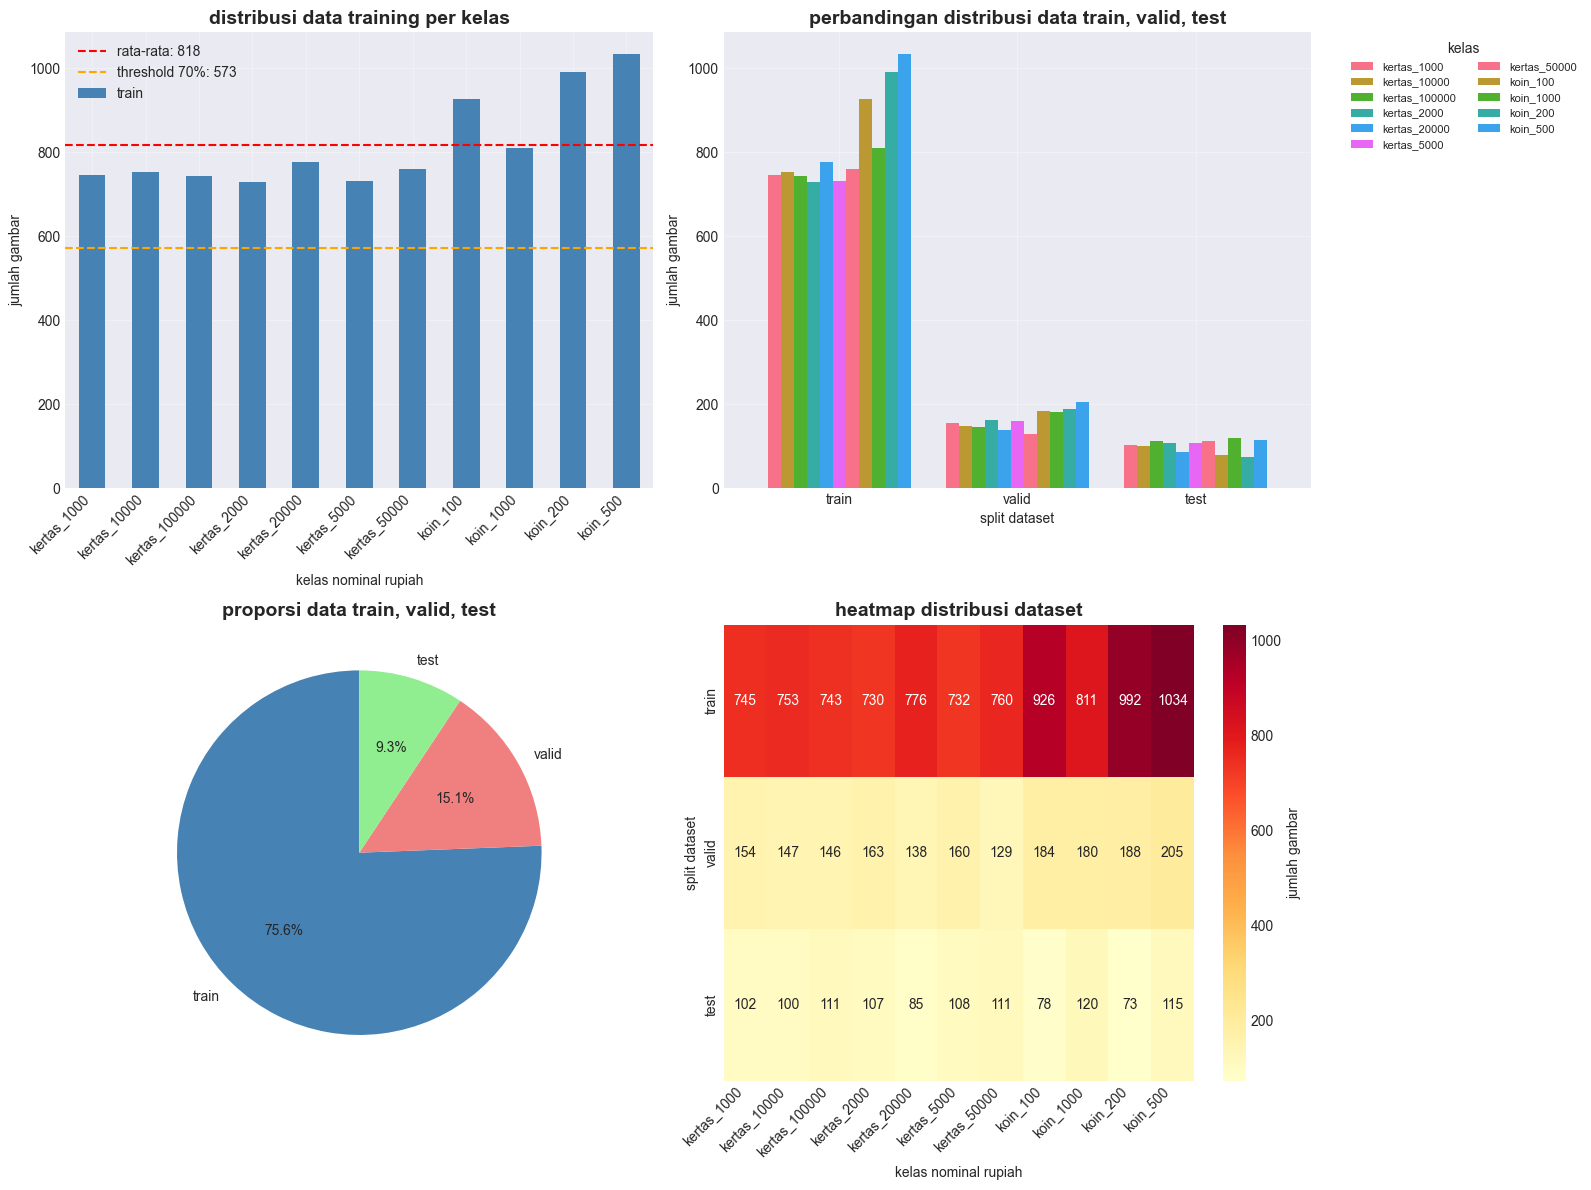

In [37]:
# visualisasi distribusi dataset: comprehensive charts untuk understand data distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # create 2x2 grid layout

# plot 1: bar chart distribusi training data per class
ax1 = axes[0, 0]
df_counts['train'].plot(kind='bar', ax=ax1, color='steelblue')  # bar chart dengan warna biru
ax1.axhline(y=train_mean, color='r', linestyle='--', label=f'rata-rata: {train_mean:.0f}')  # garis rata-rata
ax1.axhline(y=threshold, color='orange', linestyle='--', label=f'threshold 70%: {threshold:.0f}')  # garis threshold imbalance
ax1.set_title('distribusi data training per kelas', fontsize=14, fontweight='bold')  # judul
ax1.set_xlabel('kelas nominal rupiah')  # label x
ax1.set_ylabel('jumlah gambar')  # label y
ax1.legend()  # tampilkan legend
ax1.grid(True, alpha=0.3)  # add grid untuk readability
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')  # rotate labels

# plot 2: grouped bar chart perbandingan train/valid/test splits
ax2 = axes[0, 1]
df_plot = df_counts[['train', 'valid', 'test']].T  # transpose untuk grouping by split
df_plot.plot(kind='bar', ax=ax2, width=0.8)  # grouped bar chart
ax2.set_title('perbandingan distribusi data train, valid, test', fontsize=14, fontweight='bold')  # judul
ax2.set_xlabel('split dataset')  # label x
ax2.set_ylabel('jumlah gambar')  # label y
ax2.legend(title='kelas', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=8)  # legend di luar plot
ax2.grid(True, alpha=0.3)  # add grid
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0)  # keep x labels horizontal

# plot 3: pie chart proporsi total samples per split
ax3 = axes[1, 0]
total_per_split = [df_counts['train'].sum(), df_counts['valid'].sum(), df_counts['test'].sum()]  # total per split
colors = ['steelblue', 'lightcoral', 'lightgreen']  # distinct colors untuk setiap split
ax3.pie(total_per_split, labels=['train', 'valid', 'test'], autopct='%1.1f%%',   # pie chart dengan percentage
        colors=colors, startangle=90)  # start dari 90 degrees
ax3.set_title('proporsi data train, valid, test', fontsize=14, fontweight='bold')  # judul

# plot 4: heatmap intensity untuk see patterns across classes dan splits
ax4 = axes[1, 1]
heatmap_data = df_counts[['train', 'valid', 'test']].T  # transpose untuk rows=splits, cols=classes
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', ax=ax4, cbar_kws={'label': 'jumlah gambar'})  # heatmap dengan annotations
ax4.set_title('heatmap distribusi dataset', fontsize=14, fontweight='bold')  # judul
ax4.set_xlabel('kelas nominal rupiah')  # label x
ax4.set_ylabel('split dataset')  # label y
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')  # rotate x labels

plt.tight_layout()  # adjust spacing
plt.show()

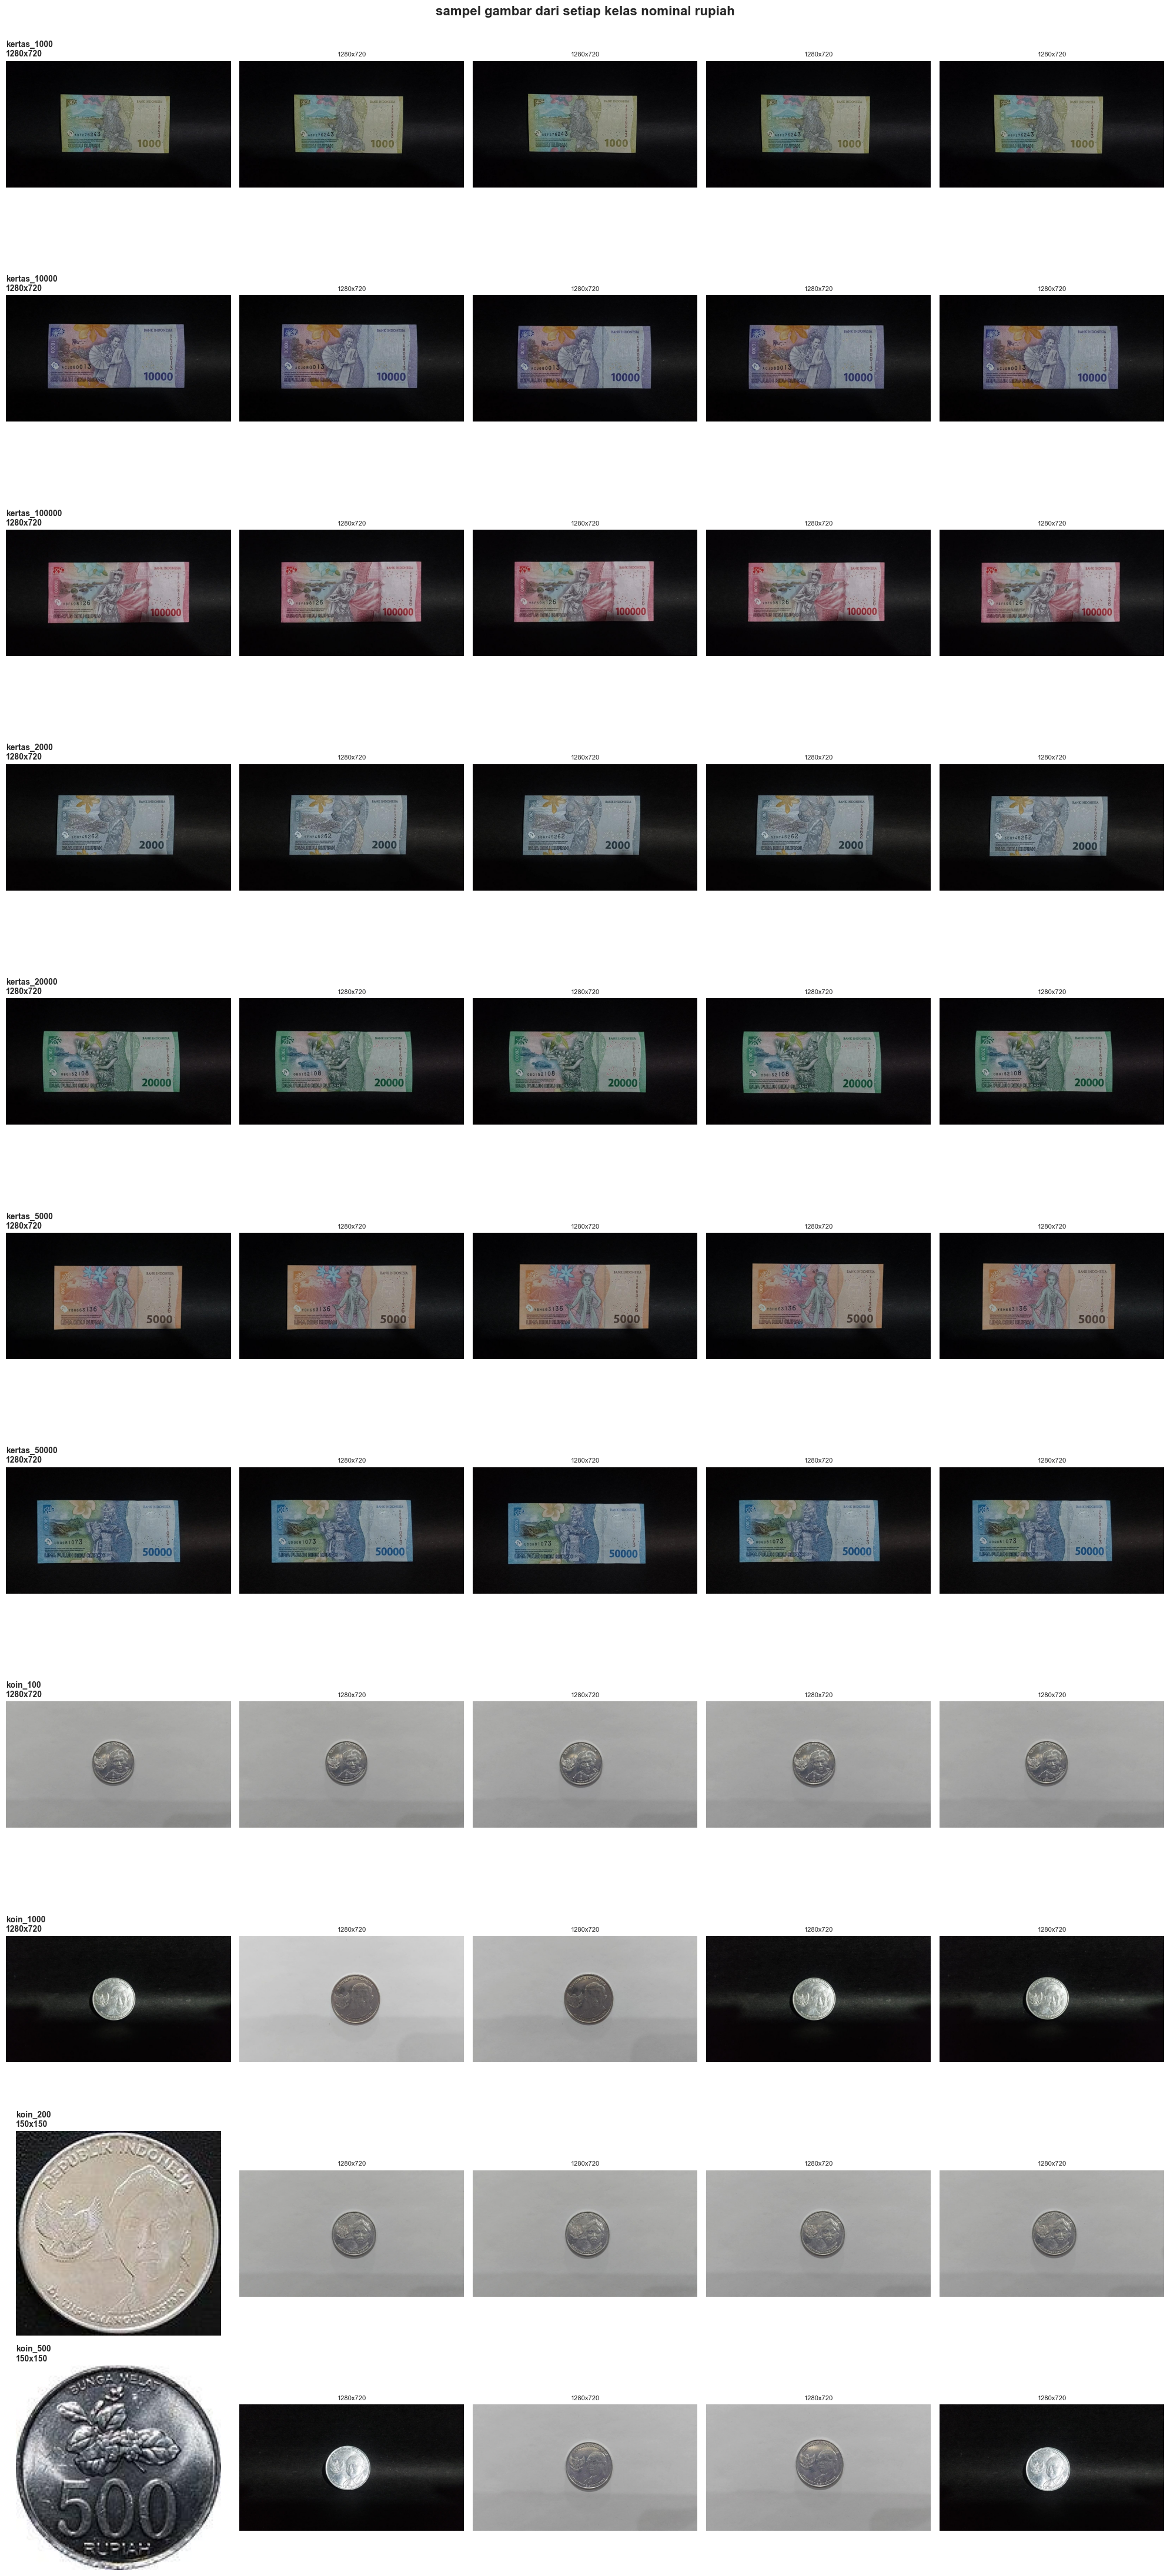

In [38]:
# visualisasi sampel gambar: display representative images dari setiap class untuk visual inspection
fig, axes = plt.subplots(11, 5, figsize=(20, 44))  # create grid 11 rows (classes) x 5 cols (samples)

# iterate setiap class untuk display sample images
for idx, class_name in enumerate(class_names):
    class_path = train_dir / class_name  # path ke class directory
    images = list(class_path.glob('*'))[:5]  # ambil 5 sample images pertama
    
    # display setiap sample image dalam row corresponding ke class
    for col, img_path in enumerate(images):
        ax = axes[idx, col]  # select subplot position
        img = Image.open(img_path)  # load image
        ax.imshow(img)  # display image
        ax.axis('off')  # hide axis untuk cleaner look
        
        # add title dengan class name di first column dan image dimensions
        if col == 0:  # first column: show class name dan dimensions
            ax.set_title(f'{class_name}\n{img.size[0]}x{img.size[1]}', 
                        fontsize=10, fontweight='bold', loc='left')
        else:  # other columns: hanya show dimensions
            ax.set_title(f'{img.size[0]}x{img.size[1]}', fontsize=8)

plt.suptitle('sampel gambar dari setiap kelas nominal rupiah', 
             fontsize=16, fontweight='bold', y=0.995)  # overall title
plt.tight_layout()  # adjust spacing
plt.show()

In [39]:
# metadata lengkap dataset: comprehensive statistics dan categorization
# step 1: categorize classes berdasarkan jenis uang (koin vs kertas)
koin_classes = [class_name for class_name in class_names if 'koin' in class_name]  # filter koin classes
kertas_classes = [class_name for class_name in class_names if 'kertas' in class_name]  # filter kertas classes

print("\nringkasan metadata dataset:")
print(f"\ntipe jenis uang:")
print(f"  koin: {len(koin_classes)} kelas")  # jumlah koin denominations
print(f"    {koin_classes}")  # list koin classes
print(f"  kertas: {len(kertas_classes)} kelas")  # jumlah kertas denominations
print(f"    {kertas_classes}")  # list kertas classes

# step 2: calculate comprehensive statistics untuk setiap split
overall_stats = pd.DataFrame({
    'metrik': ['total gambar', 'jumlah kelas', 'rata-rata per kelas', 'std deviasi', 
               'min per kelas', 'max per kelas', 'median per kelas'],  # statistical metrics
    'train': [df_counts['train'].sum(), len(class_names), df_counts['train'].mean(),
              df_counts['train'].std(), df_counts['train'].min(), df_counts['train'].max(),
              df_counts['train'].median()],  # training split stats
    'valid': [df_counts['valid'].sum(), len(class_names), df_counts['valid'].mean(),
              df_counts['valid'].std(), df_counts['valid'].min(), df_counts['valid'].max(),
              df_counts['valid'].median()],  # validation split stats
    'test': [df_counts['test'].sum(), len(class_names), df_counts['test'].mean(),
             df_counts['test'].std(), df_counts['test'].min(), df_counts['test'].max(),
             df_counts['test'].median()]  # test split stats
})

print("\nstatistik keseluruhan:")
print(overall_stats.to_string(index=False))


ringkasan metadata dataset:

tipe jenis uang:
  koin: 4 kelas
    ['koin_100', 'koin_1000', 'koin_200', 'koin_500']
  kertas: 7 kelas
    ['kertas_1000', 'kertas_10000', 'kertas_100000', 'kertas_2000', 'kertas_20000', 'kertas_5000', 'kertas_50000']

statistik keseluruhan:
             metrik       train       valid        test
       total gambar 9002.000000 1794.000000 1110.000000
       jumlah kelas   11.000000   11.000000   11.000000
rata-rata per kelas  818.363636  163.090909  100.909091
        std deviasi  111.395936   23.526388   15.533541
      min per kelas  730.000000  129.000000   73.000000
      max per kelas 1034.000000  205.000000  120.000000
   median per kelas  760.000000  160.000000  107.000000


## 4. Data Preprocessing & Augmentation

Preprocessing dan Augmentasi adalah tahap penting yang menentukan kualitas input model dan kemampuan generalisasi. Tahap ini sangat penting untuk mengatasi beberapa tantangan dalam dataset:

**Tantangan Dataset:**

1. **Class Imbalance**: Dataset memiliki distribusi tidak seimbang (koin_100 hanya 44 gambar vs koin_500 sebanyak 516 gambar)
2. **Lack of Variation**: Gambar dalam dataset memiliki ciri-ciri yang seragam
3. **Scale Inconsistency**: Karena dataset merupakan kumpulan dari beberapa dataset, gambar memiliki dimensi yang bervariasi dan perlu dinormalisasi

**Strategi Preprocessing:**

1. **Resize**: Semua gambar di-resize ke ukuran standar 224x224
2. **Normalization**: Pixel values dinormalisasi dari range [0, 255] ke [0, 1]
3. **Batching**: Data dikelompokkan dalam batch untuk efficient memory usage dan stable gradient updates

**Strategi Augmentation:**

Augmentasi diterapkan pada training set untuk meningkatkan variasi data dan mencegah overfitting:

- **Geometric Transformations**: Rotasi (±20°), shift horizontal/vertical (±20%), zoom (±20%)
- **Shear Transformation**: Untuk simulasi perspektif yang berbeda
- **Horizontal Flip**: Mengingat uang bisa dilihat dari berbagai orientasi
- **Brightness Adjustment**: Untuk mengekspose model terhadap berbagai kondisi pencahayaan (0.8x - 1.2x)

**Validation & Test Set:**

Hanya dilakukan normalisasi tanpa augmentasi untuk memastikan evaluasi yang fair dan konsisten terhadap kemampuan model pada data asli.

In [40]:
# konfigurasi preprocessing: define global parameters untuk data preprocessing dan model input
IMG_SIZE = (224, 224)  # standard input size untuk CNN models, 224x224 adalah common choice untuk balance resolution dengan computational efficiency
BATCH_SIZE = 64  # DITINGKATKAN dari 32 ke 64 untuk mempercepat training (lebih sedikit iterations per epoch)
TARGET_SAMPLES = 500  # target ideal samples per class setelah augmentation untuk balance dataset

print("konfigurasi preprocessing:")
print(f"ukuran gambar input: {IMG_SIZE}")
print(f"batch size: {BATCH_SIZE} (ditingkatkan untuk kecepatan training)")
print(f"target sampel per kelas: {TARGET_SAMPLES}")

konfigurasi preprocessing:
ukuran gambar input: (224, 224)
batch size: 64 (ditingkatkan untuk kecepatan training)
target sampel per kelas: 500


In [41]:
# setup data augmentation: apply transformations untuk increase training data diversity
# augmentasi untuk training set: aggressive transformations untuk improve generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values dari [0,255] ke [0,1] untuk faster convergence
    rotation_range=20,  # random rotation hingga ±20 degrees untuk handle angle variations
    width_shift_range=0.2,  # random horizontal shift hingga 20% image width
    height_shift_range=0.2,  # random vertical shift hingga 20% image height
    shear_range=0.2,  # shear transformation untuk simulate perspective changes
    zoom_range=0.2,  # random zoom in/out hingga 20% untuk handle scale variations
    horizontal_flip=True,  # random horizontal flip untuk double training variations
    brightness_range=[0.8, 1.2],  # random brightness adjustment untuk handle lighting conditions
    fill_mode='nearest'  # fill strategy untuk pixels yang hilang setelah transformations
)

# augmentasi untuk validation dan test set: hanya normalization tanpa transformations
# ini penting untuk fair evaluation karena kita ingin evaluate model pada original images
valid_test_datagen = ImageDataGenerator(
    rescale=1./255  # hanya normalize, no augmentation untuk consistent evaluation
)

print("data augmentation configuration:")
print("training: rotasi, shift, shear, zoom, flip, brightness adjustment")
print("validation & test: hanya normalisasi")

data augmentation configuration:
training: rotasi, shift, shear, zoom, flip, brightness adjustment
validation & test: hanya normalisasi


In [42]:
# create data generators: setup generators untuk load dan preprocess images secara efficient
# training generator dengan augmentation enabled
train_generator = train_datagen.flow_from_directory(
    train_dir,  # directory containing training images
    target_size=IMG_SIZE,  # resize semua images ke IMG_SIZE
    batch_size=BATCH_SIZE,  # jumlah images per batch
    class_mode='categorical',  # multi-class classification dengan one-hot encoding
    shuffle=True,  # shuffle data setiap epoch untuk prevent order bias
    seed=42  # random seed untuk reproducibility
)

# validation generator tanpa augmentation
valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir,  # directory containing validation images
    target_size=IMG_SIZE,  # resize ke same size sebagai training
    batch_size=BATCH_SIZE,  # batch size consistency
    class_mode='categorical',  # same class mode
    shuffle=False,  # tidak shuffle untuk validation agar consistent evaluation
    seed=42  # seed untuk reproducibility
)

# test generator tanpa augmentation
test_generator = valid_test_datagen.flow_from_directory(
    test_dir,  # directory containing test images
    target_size=IMG_SIZE,  # resize ke same size
    batch_size=BATCH_SIZE,  # batch size consistency
    class_mode='categorical',  # same class mode
    shuffle=False,  # tidak shuffle untuk test agar reproducible results
    seed=42 
)

print(f"\ndata generator berhasil dibuat:")
print(f"training samples: {train_generator.samples}")
print(f"validation samples: {valid_generator.samples}")
print(f"testing samples: {test_generator.samples}")
print(f"\nclass indices: {train_generator.class_indices}")
print(f"\npreprocessing: semua gambar diproses dengan RGB normal")

Found 9002 images belonging to 11 classes.
Found 1794 images belonging to 11 classes.
Found 1794 images belonging to 11 classes.
Found 1110 images belonging to 11 classes.

data generator berhasil dibuat:
training samples: 9002
validation samples: 1794
testing samples: 1110

class indices: {'kertas_1000': 0, 'kertas_10000': 1, 'kertas_100000': 2, 'kertas_2000': 3, 'kertas_20000': 4, 'kertas_5000': 5, 'kertas_50000': 6, 'koin_100': 7, 'koin_1000': 8, 'koin_200': 9, 'koin_500': 10}

preprocessing: semua gambar diproses dengan RGB normal
Found 1110 images belonging to 11 classes.

data generator berhasil dibuat:
training samples: 9002
validation samples: 1794
testing samples: 1110

class indices: {'kertas_1000': 0, 'kertas_10000': 1, 'kertas_100000': 2, 'kertas_2000': 3, 'kertas_20000': 4, 'kertas_5000': 5, 'kertas_50000': 6, 'koin_100': 7, 'koin_1000': 8, 'koin_200': 9, 'koin_500': 10}

preprocessing: semua gambar diproses dengan RGB normal


In [43]:
# compute class weights: calculate weights untuk handle imbalanced dataset
# class dengan fewer samples akan mendapat higher weight untuk balance contribution di loss function
class_weights = compute_class_weight(
    class_weight='balanced',  # automatically calculate balanced weights based on class frequencies
    classes=np.arange(len(class_names)),  # array of class indices dari 0 to n_classes-1
    y=train_generator.classes  # actual class labels dari training generator
)

# convert array ke dictionary format yang expected oleh keras fit function
class_weights_dict = dict(enumerate(class_weights))

print("\nclass weights untuk menangani imbalanced dataset:")  # print weights untuk each class
for idx, class_name in enumerate(class_names):
    weight = class_weights_dict[idx]  # weight untuk class ini
    count = train_counts[class_name]  # actual sample count
    print(f"{class_name:15} | count: {count:3} | weight: {weight:.3f}")


class weights untuk menangani imbalanced dataset:
kertas_1000     | count: 745 | weight: 1.098
kertas_10000    | count: 753 | weight: 1.087
kertas_100000   | count: 743 | weight: 1.101
kertas_2000     | count: 730 | weight: 1.121
kertas_20000    | count: 776 | weight: 1.055
kertas_5000     | count: 732 | weight: 1.118
kertas_50000    | count: 760 | weight: 1.077
koin_100        | count: 926 | weight: 0.884
koin_1000       | count: 811 | weight: 1.009
koin_200        | count: 992 | weight: 0.825
koin_500        | count: 1034 | weight: 0.791



visualisasi hasil data augmentation:


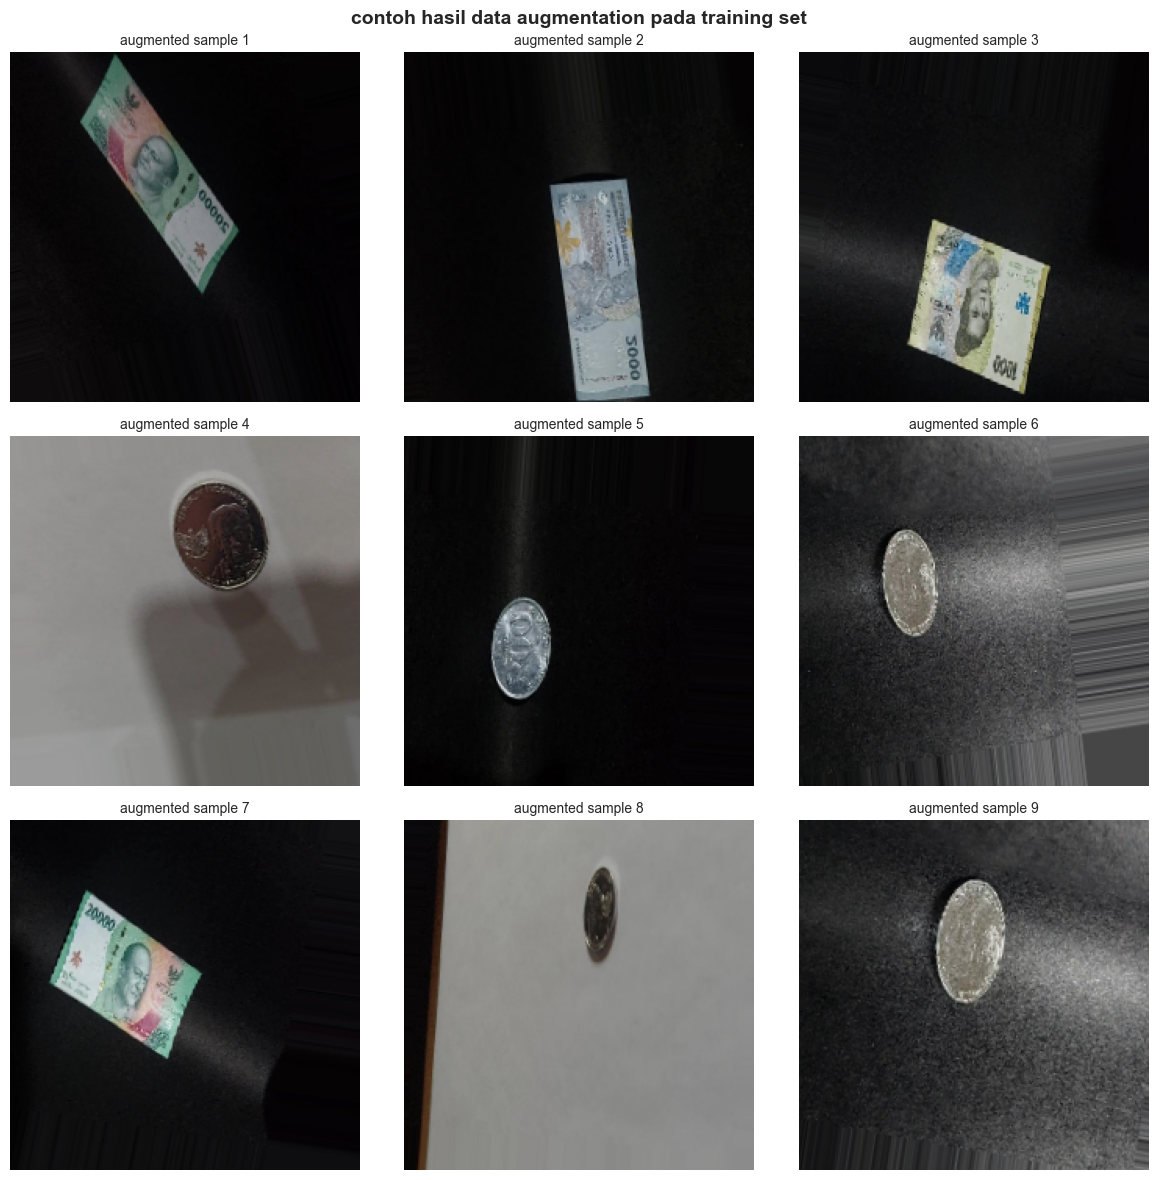

In [44]:
# visualisasi sample hasil augmentasi: verify augmentation working correctly
print("\nvisualisasi hasil data augmentation:")

# fetch satu batch dari training generator untuk see augmentation effects
sample_batch = next(train_generator)  # get next batch (images, labels)
sample_images = sample_batch[0][:9]  # extract first 9 images dari batch

# create 3x3 grid untuk display augmented samples
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()  # flatten array untuk easier iteration

# plot each augmented image
for idx, img in enumerate(sample_images):
    axes[idx].imshow(img)  # display image (already normalized to [0,1])
    axes[idx].axis('off')  # hide axis
    axes[idx].set_title(f'augmented sample {idx+1}', fontsize=10)  # label setiap sample

plt.suptitle('contoh hasil data augmentation pada training set', 
             fontsize=14, fontweight='bold')  # overall title
plt.tight_layout()  # adjust spacing
plt.show()

# reset generator setelah visualisasi agar training start dari beginning
train_generator.reset()

## 5. Model Architecture & Training Configuration

Bagian ini menjelaskan arsitektur Convolutional Neural Network (CNN) yang dirancang untuk task klasifikasi gambar uang rupiah.

**Desain Arsitektur:**

Model menggunakan arsitektur Sequential dengan hierarki ekstraksi seperti berikut:

**Layer Structure:**
- **5 Convolutional Blocks**: Ekstraksi fitur dari low-level (edges, textures) hingga high-level (shapes, patterns)
- **Progressive Filter Increase**: 32 → 64 → 128 → 256 → 512 filters untuk menangkap kompleksitas fitur yang meningkat
- **Global Average Pooling**: Menggantikan Flatten mengurangi parameters dan mencegah overfitting
- **Dense Layers**: 2 fully connected layers untuk decision making

**Regularization Techniques:**

1. **Batch Normalization**: Di setiap convolutional layer untuk normalize activations dan stabilize training
2. **Dropout**: Progressive dropout rate (0.2 → 0.3 → 0.4 → 0.5 → 0.3) untuk mencegah 'neurons' jadi mahoraga
3. **L2 Regularization**: Weight decay (0.001) pada Dense layers untuk penalize large weights
4. **Data Augmentation**: Implicit regularization melalui variasi training data

**Training Configuration:**

- **Optimizer**: Adam dengan learning rate 0.001 (adaptive learning rate dengan momentum)
- **Loss Function**: Categorical Crossentropy (standardnya multi-class classification)
- **Metrics**: Accuracy, Top-2 Accuracy, Precision, Recall untuk comprehensive evaluation
- **Max Epochs**: 50 dengan early stopping jika tidak ada improvement

**Design Decisions:**

1. **Global Average Pooling vs Flatten**: Mengurangi parameters dari ~25M menjadi ~8-10M
2. **Progressive Dropout**: Dropout lebih rendah di early layers, lebih tinggi di deeper layers
3. **Batch Normalization Placement**: Setelah Conv2D sebelum activation untuk better gradient flow
4. **Filter Size**: Konsisten 3x3 karena proven effective untuk image classification

**Expected Behavior:**

- Input: 224x224x3 RGB image
- Output: kemungkinan distribusi di rentang 11-class nominal rupiah
- Parameters: ~8-10M trainable parameters
- Training Time: tergantung spesifikasi host, (total -+ 8 jam di MX350)

In [45]:
# definisi hyperparameter untuk training process
LEARNING_RATE = 0.001  # learning rate untuk Adam optimizer, nilai standard yang proven effective
EPOCHS = 50  # maksimum epochs training, dihentikan early jika tidak ada improvement

# print konfigurasi training untuk dokumentasi dan reproducibility
print("hyperparameter training:")
print(f"learning rate: {LEARNING_RATE}")
print(f"max epochs: {EPOCHS}")
print(f"optimizer: Adam")
print(f"loss function: categorical crossentropy")
print(f"metrics: accuracy, top-2 accuracy, precision, recall")

hyperparameter training:
learning rate: 0.001
max epochs: 50
optimizer: Adam
loss function: categorical crossentropy
metrics: accuracy, top-2 accuracy, precision, recall


In [46]:
# konstruksi arsitektur CNN menggunakan sequential API dari keras
# arsitektur ini menggunakan best practices modern untuk image classification
model = models.Sequential([
    
    # input layer mendefinisikan shape input yang diharapkan
    layers.Input(shape=(224, 224, 3)),  # 224x224 pixels dengan 3 channels (RGB)
    
    # convolutional block 1: ekstraksi fitur low-level seperti edges dan textures
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_1'),  # 32 filters dengan kernel 3x3
    layers.BatchNormalization(name='bn1_1'),  # normalize activations untuk stabilize training
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_2'),  # layer Conv2D kedua untuk capture fitur lebih kompleks
    layers.BatchNormalization(name='bn1_2'),  # batch norm lagi setelah conv kedua
    layers.MaxPooling2D((2, 2), name='pool1'),  # downsample spatial dimensions 224x224 → 112x112
    layers.Dropout(0.2, name='dropout1'),  # dropout 20% untuk regularization ringan di early layers
    
    # convolutional block 2: ekstraksi fitur medium-level yang lebih kompleks
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_1'),  # double filters menjadi 64
    layers.BatchNormalization(name='bn2_1'),  # normalize untuk prevent internal covariate shift
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_2'),  # conv kedua dengan same filters
    layers.BatchNormalization(name='bn2_2'),  # batch norm kedua
    layers.MaxPooling2D((2, 2), name='pool2'),  # downsample 112x112 → 56x56
    layers.Dropout(0.2, name='dropout2'),  # maintain dropout 20% untuk consistency
    
    # convolutional block 3: ekstraksi fitur abstract tingkat menengah
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_1'),  # double filters lagi menjadi 128
    layers.BatchNormalization(name='bn3_1'),  # batch norm untuk stable gradients
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_2'),  # conv kedua capture fitur lebih dalam
    layers.BatchNormalization(name='bn3_2'),  # batch norm kedua
    layers.MaxPooling2D((2, 2), name='pool3'),  # downsample 56x56 → 28x28
    layers.Dropout(0.3, name='dropout3'),  # increase dropout ke 30% karena network lebih complex
    
    # convolutional block 4: ekstraksi fitur high-level yang sangat abstract
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4_1'),  # 256 filters untuk capture high-level patterns
    layers.BatchNormalization(name='bn4_1'),  # batch norm untuk training stability
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4_2'),  # conv kedua untuk representasi lebih kaya
    layers.BatchNormalization(name='bn4_2'),  # batch norm kedua
    layers.MaxPooling2D((2, 2), name='pool4'),  # downsample 28x28 → 14x14
    layers.Dropout(0.3, name='dropout4'),  # maintain dropout 30%
    
    # convolutional block 5: ekstraksi fitur paling abstract dan class-specific
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1'),  # 512 filters maksimum untuk deepest representations
    layers.BatchNormalization(name='bn5_1'),  # batch norm untuk prevent gradient issues
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2'),  # conv kedua dengan sama filters
    layers.BatchNormalization(name='bn5_2'),  # batch norm kedua
    layers.MaxPooling2D((2, 2), name='pool5'),  # downsample 14x14 → 7x7
    layers.Dropout(0.4, name='dropout5'),  # increase dropout ke 40% karena representation sangat abstract
    
    # global average pooling
    layers.GlobalAveragePooling2D(name='global_avg_pool'),  # average setiap 7x7 feature map menjadi single value, drastically reduce parameters
    layers.BatchNormalization(name='bn_global'),  # normalize sebelum fully connected layers
    
    # fully connected layers: decision making berdasarkan extracted features
    layers.Dense(512, activation='relu',  # 512 neurons untuk high-capacity representation
                kernel_regularizer=keras.regularizers.l2(0.001),  # L2 regularization untuk penalize large weights
                name='fc1'),
    layers.BatchNormalization(name='bn_fc1'),  # batch norm untuk stable activations
    layers.Dropout(0.5, name='dropout_fc1'),  # aggressive dropout 50% untuk prevent overfitting di dense layer
    
    layers.Dense(256, activation='relu',  # 256 neurons untuk intermediate representation
                kernel_regularizer=keras.regularizers.l2(0.001),  # L2 regularization lagi
                name='fc2'),
    layers.BatchNormalization(name='bn_fc2'),  # batch norm kedua
    layers.Dropout(0.3, name='dropout_fc2'),  # reduce dropout ke 30% sebelum output
    
    # output layer: probability distribution across 11 rupiah classes
    layers.Dense(len(class_names), activation='softmax', name='output')  # softmax untuk multi-class probability distribution
])

print("arsitektur model cnn berhasil dibuat")

arsitektur model cnn berhasil dibuat


In [47]:
# kompilasi model: mendefinisikan optimizer, loss function, dan metrics untuk training
# pemilihan ini berdasarkan best practices untuk multi-class image classification
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),  # adam optimizer dengan lr 0.001, adaptive learning rate yang efisien
    loss='categorical_crossentropy',  # loss function untuk multi-class classification dengan one-hot encoding
    metrics=['accuracy']  # metric utama untuk evaluasi adalah accuracy
)

# print summary untuk verifikasi arsitektur dan parameter count
model.summary()

# hitung total parameter
total_params = model.count_params()
trainable_params = np.sum([tf.size(v).numpy() for v in model.trainable_weights])
non_trainable_params = np.sum([tf.size(v).numpy() for v in model.non_trainable_weights])

print(f"\ntotal parameters: {total_params:,}")
print(f"trainable parameters: {trainable_params:,}")
print(f"non-trainable parameters: {non_trainable_params:,}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 224, 224, 32)      896       
                                                                 
 bn1_1 (BatchNormalization)  (None, 224, 224, 32)      128       
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 32)      9248      
                                                                 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 224, 224, 32)      896       
                                                                 
 bn1_1 (BatchNormalization)  (None, 224, 224, 32)      128       
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 32)     

In [48]:
# setup callbacks: mekanisme untuk monitoring dan optimalisasi training process secara otomatis
# callbacks ini akan dijalankan pada checkpoint tertentu selama training (setiap epoch)

# direktori untuk menyimpan checkpoint dan logs
checkpoint_dir = Path('../checkpoints')  # lokasi untuk simpan best model
log_dir = Path('../logs')  # lokasi untuk tensorboard logs
checkpoint_dir.mkdir(exist_ok=True)  # buat direktori jika belum ada
log_dir.mkdir(exist_ok=True)  # buat direktori log jika belum ada

# callback 1: model checkpoint - auto save model terbaik berdasarkan metric tertentu
checkpoint_callback = ModelCheckpoint(
    filepath=str(checkpoint_dir / 'best_model.keras'),  # path untuk save model dalam format keras (recommended untuk TF 2.10+)
    monitor='val_accuracy',  # metric yang dimonitor adalah validation accuracy
    save_best_only=True,  # hanya save jika val_accuracy lebih baik dari sebelumnya
    mode='max',  # mode max karena kita ingin maximize accuracy
    verbose=1  # print informasi setiap kali model disimpan
)

# callback 2: early stopping - stop training otomatis jika tidak ada improvement untuk prevent wasting time
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # monitor validation accuracy untuk detect plateau
    patience=7,  # tunggu 7 epochs tanpa improvement sebelum stop training
    mode='max',  # maximize val_accuracy
    verbose=1,  # print notification saat early stopping triggered
    restore_best_weights=True  # kembalikan weights ke epoch terbaik setelah stop, bukan epoch terakhir
)

# callback 3: reduce learning rate on plateau - auto tuning learning rate untuk escape local minima
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',  # monitor val_loss karena lebih sensitif daripada accuracy
    factor=0.5,  # kurangi learning rate menjadi setengahnya (lr = lr * 0.5)
    patience=3,  # tunggu 3 epochs tanpa improvement sebelum reduce lr
    min_lr=1e-7,  # batas minimum learning rate agar tidak terlalu kecil
    mode='min',  # minimize val_loss
    verbose=1  # print notification saat lr dikurangi
)

# callback 4: tensorboard - logging metrics dan visualisasi training progress secara real-time
tensorboard_callback = TensorBoard(
    log_dir=str(log_dir),  # direktori untuk simpan tensorboard logs
    histogram_freq=1,  # frekuensi logging histogram weights (setiap 1 epoch)
    write_graph=True,  # save computational graph untuk visualization
    write_images=False,  # tidak perlu save images untuk save disk space
    update_freq='epoch'  # update logs setiap epoch selesai
)

# gabungkan semua callbacks dalam satu list untuk pass ke model.fit()
callbacks_list = [
    checkpoint_callback,
    early_stopping_callback,
    reduce_lr_callback,
    tensorboard_callback
]

print("callbacks berhasil dikonfigurasi:")
print(f"1. ModelCheckpoint: save best model ke {checkpoint_dir / 'best_model.keras'}")
print("2. EarlyStopping: stop jika val_accuracy tidak improve dalam 7 epochs")
print("3. ReduceLROnPlateau: reduce lr jika val_loss plateau dalam 3 epochs")
print(f"4. TensorBoard: logging ke {log_dir}")

callbacks berhasil dikonfigurasi:
1. ModelCheckpoint: save best model ke ..\checkpoints\best_model.keras
2. EarlyStopping: stop jika val_accuracy tidak improve dalam 7 epochs
3. ReduceLROnPlateau: reduce lr jika val_loss plateau dalam 3 epochs
4. TensorBoard: logging ke ..\logs


In [ ]:
# training model: proses pembelajaran dari data training dengan monitoring validation performance
# langkah 1: hitung berapa banyak iteration (steps) per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE  # total training samples dibagi batch size
validation_steps = valid_generator.samples // BATCH_SIZE  # total validation samples dibagi batch size

print(f"steps per epoch: {steps_per_epoch}")
print(f"validation steps: {validation_steps}\n")

# langkah 2: jalankan training loop dengan fit function
# training akan berlangsung selama max EPOCHS atau sampai early stopping triggered
history = model.fit(
    train_generator,  # data generator untuk training set
    steps_per_epoch=steps_per_epoch,  # jumlah batches per epoch
    epochs=EPOCHS,  # maksimum 50 epochs
    validation_data=valid_generator,  # data generator untuk validation set
    validation_steps=validation_steps,  # jumlah validation batches
    callbacks=callbacks_list,  # apply semua callbacks yang sudah didefinisikan
    class_weight=class_weights_dict,  # gunakan class weights untuk handle imbalanced dataset
    verbose=1  # print progress bar dan metrics setiap epoch
)

print("\ntraining selesai")

steps per epoch: 140
validation steps: 28


validation steps: 28

Epoch 1/50
Epoch 1/50
 41/140 [=======>......................] - ETA: 33:47 - loss: 2.3567 - accuracy: 0.4950

## 6. Evaluasi Model

Tahap evaluasi mengukur seberapa baik model bekerja pada data yang belum pernah dilihat sebelumnya. pada tahap ini, kita tidak hanya melihat accuracy, tetapi juga menganalisis perilaku model secara detail melalui berbagai metrik yang divisualisasikan.

**Proses Evaluasi:**

1. **Visualisasi Training History**: plot learning curves untuk melihat progression training dan validation metrics selama epochs. ini membantu identify apakah model mengalami overfitting (training accuracy tinggi tapi validation rendah) atau underfitting (kedua accuracy rendah).

2. **Evaluasi Quantitative**: menghitung performance metrics pada test set yang completely unseen. metrics yang digunakan mencakup:
   - accuracy: persentase prediksi benar dari total prediksi
   - precision: dari semua prediksi positive untuk class tertentu, berapa persen yang benar
   - recall: dari semua actual instances class tertentu, berapa persen yang berhasil diprediksi
   - f1-score: harmonic mean antara precision dan recall, balance metric

3. **Confusion Matrix**: visualisasi matrix yang menunjukkan pola kesalahan prediksi. setiap cell (i,j) menunjukkan berapa banyak instances dari class i yang diprediksi sebagai class j. diagonal matrix menunjukkan correct predictions, sedangkan off-diagonal menunjukkan misclassifications. ini sangat berguna untuk identify class pairs yang sering confused oleh model.

4. **per-class Analysis**: mengidentifikasi class mana yang sulit diprediksi dan mengapa. class dengan recall rendah berarti model sering miss instances dari class tersebut, sedangkan precision rendah berarti model sering false positive untuk class itu.

**Expected Outcomes:**
- learning curves yang smooth tanpa wild oscillation menunjukkan training yang stable
- gap kecil antara training dan validation metrics menunjukkan good generalization
- confusion matrix dengan values concentrated di diagonal menunjukkan reliable predictions
- balanced performance across all classes menunjukkan model tidak bias terhadap majority class

In [ ]:
# visualisasi training history: plot learning curves untuk analyze training progression
# ini membantu detect overfitting/underfitting dan validate effectiveness dari callbacks

# - accuracy: persentase prediksi yang benar dari total prediksi (correct/total)
# - val_accuracy: accuracy yang diukur pada validation set (data yang tidak digunakan untuk training)
#   * digunakan untuk monitor apakah model generalize well atau hanya hafal training data
#   * jika val_accuracy jauh lebih rendah dari train accuracy → overfitting
# - loss: nilai error function yang diminimize oleh model (categorical crossentropy)
#   * semakin rendah semakin baik, mengukur seberapa confident model dalam prediksi yang benar
# - val_loss: loss yang diukur pada validation set
#   * digunakan untuk early stopping dan reduce learning rate decisions

fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # create 2x2 grid untuk 4 plots


# plot 1: accuracy progression selama training
# memvisualisasikan peningkatan accuracy dari epoch ke epoch
# train accuracy: seberapa baik model memprediksi data training (biasanya terus naik)
# val_accuracy: seberapa baik model memprediksi data baru yang belum pernah dilihat
ax1 = axes[0, 0]  # subplot posisi kiri atas
ax1.plot(history.history['accuracy'], label='train accuracy', linewidth=2)  # plot training accuracy
ax1.plot(history.history['val_accuracy'], label='validation accuracy', linewidth=2)  # plot validation accuracy
ax1.set_title('training dan validation accuracy', fontsize=14, fontweight='bold')  # judul plot
ax1.set_xlabel('epoch')  # label sumbu x
ax1.set_ylabel('accuracy')  # label sumbu y
ax1.legend()  # tampilkan legend
ax1.grid(True, alpha=0.3)  # tambahkan grid untuk readability

# plot 2: loss progression untuk see convergence behavior
# loss menunjukkan seberapa besar error model dalam prediksi
# ideal: kedua curve turun smooth dan converge ke nilai stabil
ax2 = axes[0, 1]  # subplot posisi kanan atas
ax2.plot(history.history['loss'], label='train loss', linewidth=2)  # plot training loss
ax2.plot(history.history['val_loss'], label='validation loss', linewidth=2)  # plot validation loss
ax2.set_title('training dan validation loss', fontsize=14, fontweight='bold')  # judul plot
ax2.set_xlabel('epoch')  # label sumbu x
ax2.set_ylabel('loss')  # label sumbu y
ax2.legend()  # tampilkan legend
ax2.grid(True, alpha=0.3)  # tambahkan grid

# plot 3: gap antara training dan validation accuracy untuk detect overfitting
# gap besar (positif) → model overfitting (hafal training data, tidak generalize)
# gap kecil → model generalize dengan baik
# gap negatif → unusual, mungkin validation set lebih mudah atau ada data leakage
ax3 = axes[1, 0]  # subplot posisi kiri bawah
gap = [train - val for train, val in zip(history.history['accuracy'], history.history['val_accuracy'])]  # calculate gap
ax3.plot(gap, linewidth=2, color='red')  # plot gap dengan warna merah
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)  # garis horizontal di y=0 sebagai reference
ax3.set_title('accuracy gap (train - validation)', fontsize=14, fontweight='bold')  # judul plot
ax3.set_xlabel('epoch')  # label sumbu x
ax3.set_ylabel('gap')  # label sumbu y
ax3.grid(True, alpha=0.3)  # tambahkan grid

# plot 4: learning rate changes untuk see effect dari ReduceLROnPlateau callback
# learning rate: seberapa besar step yang diambil model saat update weights
# callback akan reduce learning rate saat model stuck di plateau untuk fine-tuning
ax4 = axes[1, 1]  # subplot posisi kanan bawah
if 'lr' in history.history:  # check jika lr dilogging
    ax4.plot(history.history['lr'], linewidth=2, color='green')  # plot learning rate progression
    ax4.set_title('learning rate changes', fontsize=14, fontweight='bold')  # judul plot
    ax4.set_xlabel('epoch')  # label sumbu x
    ax4.set_ylabel('learning rate')  # label sumbu y
    ax4.set_yscale('log')  # gunakan log scale karena lr bisa sangat kecil
    ax4.grid(True, alpha=0.3)  # tambahkan grid
else:
    ax4.text(0.5, 0.5, 'learning rate tidak dilogging', ha='center', va='center', fontsize=12)  # fallback jika lr tidak tersedia
    ax4.axis('off')  # hide axes

plt.tight_layout()  # adjust spacing untuk prevent overlapping
plt.show()

In [ ]:
# analisis overfitting/underfitting: check kesehatan model berdasarkan gap antara train dan validation
# gap yang terlalu besar menunjukkan overfitting, gap yang terlalu kecil dengan accuracy rendah menunjukkan underfitting
final_train_acc = history.history['accuracy'][-1]  # ambil training accuracy di epoch terakhir
final_val_acc = history.history['val_accuracy'][-1]  # ambil validation accuracy di epoch terakhir
acc_gap = final_train_acc - final_val_acc  # calculate gap

print("\nanalisis overfitting/underfitting:")
print(f"final training accuracy: {final_train_acc:.4f}")
print(f"final validation accuracy: {final_val_acc:.4f}")
print(f"accuracy gap: {acc_gap:.4f}")

# interpretasi gap untuk diagnose model health
if acc_gap < 0.05:  # gap sangat kecil (kurang dari 5%)
    print("\nkesimpulan: model well-fitted")
    print("gap antara training dan validation accuracy sangat kecil, menunjukkan generalisasi yang baik")
elif acc_gap < 0.10:  # gap moderate (5-10%)
    print("\nkesimpulan: model slight overfitting")
    print("gap antara training dan validation accuracy masih dalam batas wajar untuk model deep learning")
else:  # gap besar (lebih dari 10%)
    print("\nkesimpulan: model overfitting")
    print("perlu tambahan regularisasi atau data augmentation untuk meningkatkan generalisasi")

In [ ]:
# evaluasi model pada test set: mengukur performance pada data completely unseen
# ini adalah true measure dari model generalization capability
print("\nevaluasi model pada test set...")

# jalankan evaluasi dengan metrics yang sudah dikompilasi
test_results = model.evaluate(
    test_generator,  # data test yang belum pernah dilihat model
    steps=test_generator.samples // BATCH_SIZE,  # jumlah batches untuk evaluate
    verbose=1  # show progress bar
)

# extract metrics (karena TF 2.10 mengembalikan list)
test_loss = test_results[0]
test_accuracy = test_results[1] if len(test_results) > 1 else test_results[0]

# print hasil evaluasi dasar
print("\nhasil evaluasi pada test set:")
print(f"test loss: {test_loss:.4f}")  # categorical crossentropy loss value
print(f"test accuracy: {test_accuracy:.4f}")  # top-1 accuracy

In [ ]:
# generate predictions untuk confusion matrix dan classification report
# kita perlu predicted classes dan true classes untuk detailed per-class analysis
print("\nmembuat prediksi pada test set...")

# reset generator untuk ensure consistent ordering dari data
test_generator.reset()  # return generator ke awal sequence

# generate predictions: model.predict return probability distribution untuk setiap class
# contoh output: [[0.05, 0.85, 0.10], [0.90, 0.05, 0.05], ...]
# dimana setiap row adalah probability untuk 11 classes (koin_100, koin_200, ..., kertas_100000)
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)  # shape: (n_samples, n_classes)
y_pred = np.argmax(y_pred_proba, axis=1)  # convert probabilities ke class indices dengan argmax (ambil class dengan prob tertinggi)

# extract true labels dari generator
y_true = test_generator.classes[:len(y_pred)]  # ambil true class indices sesuai panjang predictions

# verify consistency antara predictions dan labels
print(f"\njumlah prediksi: {len(y_pred)}")
print(f"jumlah true labels: {len(y_true)}")

# calculate precision, recall, f1 dari predictions untuk melengkapi evaluasi
from sklearn.metrics import precision_score, recall_score

test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)

# print metrics yang lebih detail
print(f"\nmetrics tambahan:")
print(f"test precision: {test_precision:.4f}")  # ratio true positives dari all positive predictions
print(f"test recall: {test_recall:.4f}")  # ratio true positives dari all actual positives
print(f"test f1-score: {test_f1:.4f}")  # balance metric antara precision dan recall

In [ ]:
# visualisasi confusion matrix: heatmap untuk analyze prediction patterns
# KEGUNAAN CONFUSION MATRIX:
# - menunjukkan dimana model membuat kesalahan (confusion) antara class yang berbeda
# - diagonal (kiri atas ke kanan bawah) = prediksi yang benar
# - cell di luar diagonal = kesalahan prediksi
# - contoh: jika cell [koin_500][koin_1000] bernilai tinggi → model sering salah prediksi koin_500 sebagai koin_1000
# - membantu identify class-pair yang mirip dan sulit dibedakan oleh model

cm = confusion_matrix(y_true, y_pred)  # calculate confusion matrix dari true dan predicted labels

# create heatmap visualization dengan seaborn
# heatmap: representasi visual dengan warna, semakin gelap semakin banyak prediksi
plt.figure(figsize=(14, 12))  # ukuran figure yang besar untuk accommodate 11x11 matrix
sns.heatmap(
    cm,  # confusion matrix data
    annot=True,  # tampilkan numbers di setiap cell untuk lihat jumlah exact
    fmt='d',  # format sebagai integer (decimal)
    cmap='Blues',  # color palette biru gradient (putih=sedikit, biru tua=banyak)
    xticklabels=class_names,  # label sumbu x dengan nama class (predicted)
    yticklabels=class_names,  # label sumbu y dengan nama class (true/actual)
    cbar_kws={'label': 'jumlah prediksi'}  # colorbar label
)
plt.title('confusion matrix - test set', fontsize=16, fontweight='bold', pad=20)  # judul plot
plt.xlabel('predicted label', fontsize=12)  # label sumbu x (apa yang diprediksi model)
plt.ylabel('true label', fontsize=12)  # label sumbu y (label sebenarnya)
plt.xticks(rotation=45, ha='right')  # rotate x labels untuk readability
plt.yticks(rotation=0)  # y labels horizontal
plt.tight_layout()  # adjust layout
plt.show()

In [ ]:
# normalized confusion matrix: tampilkan dalam persentase untuk easier interpretation
# KEGUNAAN NORMALIZED CONFUSION MATRIX:
# - normalization per row (setiap baris dijumlahkan = 100%)
# - menunjukkan persentase prediksi untuk setiap true class
# - diagonal menunjukkan recall/sensitivity per class (seberapa baik model detect class tersebut)
# - lebih mudah dibaca daripada raw count terutama jika class imbalanced
# - warna hijau = recall tinggi (bagus), merah = recall rendah (buruk)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # divide each row by row sum untuk dapat persentase

# visualisasi dengan diverging colormap untuk highlight good/bad performance
plt.figure(figsize=(14, 12))  # ukuran besar untuk clarity
sns.heatmap(
    cm_normalized,  # normalized confusion matrix data
    annot=True,  # tampilkan persentase di setiap cell
    fmt='.2%',  # format sebagai percentage dengan 2 decimal places (contoh: 95.50%)
    cmap='RdYlGn',  # red-yellow-green diverging colormap (red=bad/rendah, green=good/tinggi)
    xticklabels=class_names,  # label sumbu x dengan nama class
    yticklabels=class_names,  # label sumbu y dengan nama class
    cbar_kws={'label': 'persentase', 'format': '%.0f%%'},  # colorbar configuration
    vmin=0,  # minimum value 0%
    vmax=1  # maximum value 100%
)
plt.title('normalized confusion matrix - test set', fontsize=16, fontweight='bold', pad=20)  # judul plot
plt.xlabel('predicted label', fontsize=12)  # label sumbu x
plt.ylabel('true label', fontsize=12)  # label sumbu y
plt.xticks(rotation=45, ha='right')  # rotate x labels
plt.yticks(rotation=0)  # y labels horizontal
plt.tight_layout()  # adjust layout
plt.show()

In [ ]:
# classification report: detailed per-class metrics untuk comprehensive performance analysis
# report ini menunjukkan precision, recall, f1-score, dan support untuk setiap class
print("\nclassification report:")
report = classification_report(
    y_true,  # true labels
    y_pred,  # predicted labels
    target_names=class_names,  # gunakan nama class untuk readability
    digits=4  # tampilkan 4 decimal places untuk precision metrics
)
print(report)

In [ ]:
# visualisasi per-class metrics: bar charts untuk compare performance across different classes
# ini membantu identify which classes perform well dan which ones struggle

# PENJELASAN METRICS PER-CLASS:
# - PRECISION: dari semua yang diprediksi sebagai class X, berapa persen yang benar?
#   * precision tinggi = sedikit false positive (model jarang salah bilang sesuatu adalah X)
#   * rumus: TP / (TP + FP)
#   * contoh: precision koin_1000 = 0.95 → 95% prediksi "koin_1000" memang benar koin_1000
#
# - RECALL (sensitivity): dari semua data yang sebenarnya class X, berapa persen yang berhasil terdeteksi?
#   * recall tinggi = sedikit false negative (model jarang miss class X)
#   * rumus: TP / (TP + FN)
#   * contoh: recall koin_1000 = 0.90 → 90% koin_1000 yang sebenarnya berhasil dikenali
#
# - F1-SCORE: harmonic mean dari precision dan recall (balance metric)
#   * f1 tinggi = model bagus untuk class tersebut (precision dan recall tinggi)
#   * rumus: 2 * (precision * recall) / (precision + recall)
#   * lebih reliable daripada accuracy untuk imbalanced dataset
#
# - SUPPORT: jumlah sample class tersebut di test set (untuk context)

from sklearn.metrics import precision_recall_fscore_support

# extract individual metrics untuk setiap class
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=range(len(class_names))  # calculate untuk semua classes
)

# organize metrics dalam dataframe untuk easier manipulation dan visualization
metrics_df = pd.DataFrame({
    'class': class_names,  # nama class sebagai index
    'precision': precision,  # precision per class
    'recall': recall,  # recall per class
    'f1-score': f1,  # f1-score per class
    'support': support  # jumlah samples per class di test set
})

# create 2x2 subplot grid untuk visualize semua metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# plot 1: precision per class - measure of prediction accuracy untuk positive class
# bar tinggi = model confident dan accurate saat prediksi class tersebut
ax1 = axes[0, 0]
metrics_df.plot(x='class', y='precision', kind='bar', ax=ax1, color='steelblue', legend=False)  # bar chart precision
ax1.set_title('precision per kelas', fontsize=14, fontweight='bold')  # judul
ax1.set_xlabel('kelas nominal rupiah')  # label x
ax1.set_ylabel('precision')  # label y
ax1.set_ylim([0, 1.1])  # set y limit 0-1.1 untuk accommodate legend
ax1.axhline(y=test_precision, color='r', linestyle='--', label=f'rata-rata: {test_precision:.3f}')  # garis rata-rata
ax1.legend()  # tampilkan legend
ax1.grid(True, alpha=0.3)  # add grid
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')  # rotate x labels

# plot 2: recall per class - measure of coverage untuk true positive instances
# bar tinggi = model jarang miss/melewatkan class tersebut
ax2 = axes[0, 1]
metrics_df.plot(x='class', y='recall', kind='bar', ax=ax2, color='lightcoral', legend=False)  # bar chart recall
ax2.set_title('recall per kelas', fontsize=14, fontweight='bold')  # judul
ax2.set_xlabel('kelas nominal rupiah')  # label x
ax2.set_ylabel('recall')  # label y
ax2.set_ylim([0, 1.1])  # set y limit
ax2.axhline(y=test_recall, color='r', linestyle='--', label=f'rata-rata: {test_recall:.3f}')  # garis rata-rata
ax2.legend()  # tampilkan legend
ax2.grid(True, alpha=0.3)  # add grid
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')  # rotate x labels

# plot 3: f1-score per class - harmonic mean dari precision dan recall
# bar tinggi = model perform well overall untuk class tersebut (balance precision & recall)
ax3 = axes[1, 0]
metrics_df.plot(x='class', y='f1-score', kind='bar', ax=ax3, color='lightgreen', legend=False)  # bar chart f1
ax3.set_title('f1-score per kelas', fontsize=14, fontweight='bold')  # judul
ax3.set_xlabel('kelas nominal rupiah')  # label x
ax3.set_ylabel('f1-score')  # label y
ax3.set_ylim([0, 1.1])  # set y limit
ax3.axhline(y=test_f1, color='r', linestyle='--', label=f'rata-rata: {test_f1:.3f}')  # garis rata-rata
ax3.legend()  # tampilkan legend
ax3.grid(True, alpha=0.3)  # add grid
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')  # rotate x labels

# plot 4: support per class - jumlah samples di test set
# penting untuk context: metric dari class dengan support rendah less reliable
ax4 = axes[1, 1]
metrics_df.plot(x='class', y='support', kind='bar', ax=ax4, color='lightyellow', edgecolor='black', legend=False)  # bar chart support
ax4.set_title('support per kelas (jumlah sample di test set)', fontsize=14, fontweight='bold')  # judul
ax4.set_xlabel('kelas nominal rupiah')  # label x
ax4.set_ylabel('jumlah sample')  # label y
ax4.grid(True, alpha=0.3)  # add grid
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')  # rotate x labels

plt.tight_layout()  # adjust spacing
plt.show()

# print summary untuk quick overview
print("\nringkasan per-class performance:")
print(metrics_df.to_string(index=False))

In [ ]:
# analisis kesalahan prediksi: identify dan analyze misclassified instances
# ini membantu understand where dan why model makes mistakes
misclassified_indices = np.where(y_pred != y_true)[0]  # find indices where prediction tidak match true label
print(f"\njumlah kesalahan klasifikasi: {len(misclassified_indices)}")
print(f"persentase kesalahan: {len(misclassified_indices)/len(y_true)*100:.2f}%")

# tampilkan sample dari kesalahan klasifikasi untuk manual inspection
if len(misclassified_indices) > 0:  # check jika ada misclassification
    print("\ncontoh kesalahan klasifikasi:")
    
    # random sample beberapa errors untuk analysis
    sample_errors = np.random.choice(misclassified_indices, min(10, len(misclassified_indices)), replace=False)
    
    # print details dari setiap error untuk understand pattern
    for idx in sample_errors:
        true_class = class_names[y_true[idx]]  # actual class
        pred_class = class_names[y_pred[idx]]  # predicted class
        confidence = y_pred_proba[idx][y_pred[idx]] * 100  # confidence level untuk wrong prediction
        print(f"true: {true_class:15} | predicted: {pred_class:15} | confidence: {confidence:.2f}%")

## 7. Simpan Model

Setelah training dan evaluasi selesai, model perlu disimpan untuk future use dan deployment. penyimpanan dalam multiple formats memastikan kompatibilitas dengan berbagai deployment scenarios dan tools.

**Format Penyimpanan:**

1. **Keras Native Format (.keras)**: format yang di-recommended oleh tensorflow/keras. format ini adalah single-file yang mencakup:
   - arsitektur model dalam JSON
   - weights dalam binary format
   - optimizer state untuk resume training
   - training configuration (loss, metrics, optimizer config)
   
   format ini lebih efficient dan reliable dibanding format lama, serta fully supports semua keras features termasuk custom layers dan objects.

2. **h5 Format (.h5)**: legacy format berbasis HDF5 yang masih widely supported untuk backward compatibility. format ini berguna jika kita perlu interoperability dengan older tensorflow versions atau external tools yang belum support keras format.

3. **Metadata File**: informasi detail tentang model, training process, dan performance metrics disimpan dalam JSON format. ini sangat berguna untuk:
   - documentation dan versioning
   - tracking experiments dan results
   - deployment decision making
   - model comparison dan selection

In [ ]:
# simpan model dalam format keras (recommended untuk TensorFlow 2.10+)
# model.save() akan save complete model: architecture + weights + optimizer state
model.save('../checkpoints/rupiah_classification_final.keras')  # save dalam keras format (recommended untuk TF 2.10+)
print("model berhasil disimpan dalam format keras (compatible dengan TensorFlow 2.10+)")

# save juga dalam format h5 untuk backward compatibility
model.save('../checkpoints/rupiah_classification_final.h5')  # save dalam h5 format untuk compatibility
print("model juga disimpan dalam format h5 untuk backward compatibility")

In [ ]:
# simpan metadata model: comprehensive information untuk documentation dan versioning
import json
from datetime import datetime

# construct metadata dictionary dengan semua informasi penting
metadata = {
    'model_name': 'Rupiah Classification CNN',  # nama model
    'version': '1.0',  # version number untuk tracking
    'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),  # timestamp creation
    'architecture': 'Custom CNN',  # architecture type
    'input_shape': list(IMG_SIZE) + [3],  # input dimensions (224, 224, 3)
    'num_classes': len(class_names),  # jumlah output classes
    'class_names': class_names,  # list nama semua classes
    'total_parameters': int(total_params),  # total trainable dan non-trainable parameters
    'trainable_parameters': int(trainable_params),  # parameters yang diupdate saat training
    'training': {  # training configuration details
        'epochs_trained': len(history.history['loss']),  # berapa epochs actually trained
        'batch_size': BATCH_SIZE,  # batch size yang digunakan
        'learning_rate': LEARNING_RATE,  # initial learning rate
        'optimizer': 'Adam',  # optimizer type
        'loss_function': 'categorical_crossentropy'  # loss function
    },
    'performance': {  # performance metrics pada semua splits
        'train_accuracy': float(final_train_acc),  # final training accuracy
        'val_accuracy': float(final_val_acc),  # final validation accuracy
        'test_accuracy': float(test_accuracy),  # test set accuracy
        'test_precision': float(test_precision),  # test set precision
        'test_recall': float(test_recall),  # test set recall
        'test_f1_score': float(test_f1)  # test set f1-score
    },
    'dataset': {  # dataset size information
        'train_samples': int(train_generator.samples),  # jumlah training samples
        'valid_samples': int(valid_generator.samples),  # jumlah validation samples
        'test_samples': int(test_generator.samples),  # jumlah test samples
        'total_samples': int(train_generator.samples + valid_generator.samples + test_generator.samples)  # total dataset size
    }
}

# print metadata dalam formatted JSON untuk readability
print("\nmetadata model:")
print(json.dumps(metadata, indent=2))

## 8. Testing Prediksi pada Gambar Baru

Tahap terakhir adalah testing model pada gambar-gambar baru untuk validate real-world usability. ini penting  karena performance pada test set tidak selalu bagus dalam penggunaan model di aplikasi.

**Fungsi yang dibuat:**

Fungsi `predict_rupiah()` dirancang untuk:
- load dan preprocess gambar sesuai dengan format yang expected oleh model
- normalize pixel values ke range [0,1] seperti saat training
- generate predictions dengan confidence scores
- return predicted class dan probability distribution

**Penggunaan Praktis:**

Prediksi dilakukan pada sample images dari test set untuk demonstrate functionality. visualisasi menunjukkan:
- gambar original
- predicted class dengan confidence level
- full probability distribution across all classes untuk transparency
- comparison dengan true label jika available

Confidence threshold dapat diimplementasikan untuk reject low-confidence predictions dan improve reliability dalam production deployment.

In [ ]:
# definisi fungsi untuk prediksi gambar tunggal: reusable function untuk inference
def predict_rupiah(image_path, model, class_names):
    """
    melakukan prediksi pada gambar tunggal dengan preprocessing yang sama seperti training
    
    args:
        image_path: path ke file gambar yang akan diprediksi
        model: model keras yang sudah trained
        class_names: list nama kelas untuk mapping index ke label
    
    returns:
        tuple: (predicted_class, confidence, all_probabilities)
    """
    # langkah 1: load gambar dengan target size yang sama seperti training
    img = load_img(image_path, target_size=IMG_SIZE)  # resize ke 224x224
    
    # langkah 2: convert PIL image ke numpy array
    img_array = img_to_array(img)  # shape: (224, 224, 3)
    
    # langkah 3: add batch dimension karena model expect batch input
    img_array = np.expand_dims(img_array, axis=0)  # shape: (1, 224, 224, 3)
    
    # langkah 4: normalize pixel values ke [0,1] seperti saat training
    img_array = img_array / 255.0  # rescale dari [0,255] ke [0,1]
    
    # langkah 5: generate predictions menggunakan trained model
    predictions = model.predict(img_array, verbose=0)  # return probability distribution
    
    # langkah 6: extract predicted class dan confidence
    predicted_class_idx = np.argmax(predictions[0])  # index dengan probability tertinggi
    predicted_class = class_names[predicted_class_idx]  # map index ke class name
    confidence = predictions[0][predicted_class_idx] * 100  # confidence dalam percentage
    
    return predicted_class, confidence, predictions[0]

print("OK")

In [ ]:
# testing prediksi pada sampel gambar: demonstrate model functionality dengan visual output
print("\ntesting prediksi pada sampel gambar random dari test set...")

# langkah 1: kumpulkan sample images dari setiap class untuk diverse testing
sample_images_paths = []  # list untuk store paths
for class_name in class_names:  # iterate semua classes
    class_path = test_dir / class_name  # path ke directory class
    images = list(class_path.glob('*'))  # get all images dalam class
    if images:  # check jika class punya images
        sample_images_paths.append(np.random.choice(images))  # pick random image

# langkah 2: visualisasi predictions dalam grid layout
fig, axes = plt.subplots(4, 3, figsize=(15, 20))  # create 4x3 grid untuk 12 images
axes = axes.ravel()  # flatten axes array untuk easier iteration

# langkah 3: process dan visualize setiap sample image
for idx, img_path in enumerate(sample_images_paths[:12]):  # limit ke 12 images
    # generate prediction menggunakan fungsi yang sudah didefinisikan
    predicted_class, confidence, probabilities = predict_rupiah(img_path, model, class_names)
    
    # extract true label dari directory structure
    true_class = img_path.parent.name  # parent directory name adalah class label
    
    # load gambar untuk visualization
    img = Image.open(img_path)
    
    # plot image di subplot
    ax = axes[idx]
    ax.imshow(img)  # display image
    ax.axis('off')  # hide axis
    
    # color code title berdasarkan correctness: green=correct, red=incorrect
    color = 'green' if predicted_class == true_class else 'red'
    
    # create informative title dengan true label, prediction, dan confidence
    title = f'true: {true_class}\npred: {predicted_class}\nconf: {confidence:.1f}%'
    ax.set_title(title, fontsize=10, fontweight='bold', color=color)

plt.suptitle('contoh prediksi pada test set\n(hijau = benar, merah = salah)', 
             fontsize=14, fontweight='bold')  # overall title untuk explain color coding
plt.tight_layout()  # adjust spacing
plt.show()

## 9. Kesimpulan & Ringkasan

Bagian ini menyajikan summary dari model yang telah dikembangkan. Ringkasan mencakup semua aspek penting dari project untuk memberikan pemahaman menyeluruh tentang apa yang telah dicapai.

**Struktur Ringkasan:**

1. **Analisis Dataset**: Overview tentang composition dan distribution data yang digunakan. ini mencakup jumlah samples per class, imbalanced classes yang perlu special attention, dan split ratios antara training/validation/test sets.

2. **Arsitektur Model**: Specifications dari CNN architecture yang dibangun, termasuk jumlah layers, filter configurations, parameter counts, dan architectural decisions yang dibuat untuk balance capacity dengan generalization.

3. **Konfigurasi Training**: Detail lengkap tentang training process, termasuk optimizer selection, hyperparameters, callbacks yang digunakan, data augmentation strategies, dan regularization techniques yang diimplement untuk improve model performance.

4. **Hasil Evaluasi**: Comprehensive metrics dari model performance pada training, validation, dan test sets. ini menunjukkan seberapa baik model generalize ke unseen data dan identify potential issues seperti overfitting atau class bias.

5. **Strengths dan Limitations**: Assessment tentang apa yang model lakukan dengan baik dan where improvement diperlukan. ini important untuk set realistic expectations dan guide future development.

In [ ]:
# ringkasan lengkap proyek: comprehensive summary dari seluruh pipeline
print("\nRINGKASAN PROYEK KLASIFIKASI UANG RUPIAH DENGAN CNN\n")

# bagian 1: analisis dataset - overview tentang data yang digunakan
print("Analisis Dataset:")
print(f"  total kelas: {len(class_names)}")  # jumlah distinct rupiah classes
print(f"  total gambar: {df_counts['total'].sum()}")  # total images across all splits
print(f"    - training: {df_counts['train'].sum()} ({df_counts['train'].sum()/df_counts['total'].sum()*100:.1f}%)")  # training split
print(f"    - validation: {df_counts['valid'].sum()} ({df_counts['valid'].sum()/df_counts['total'].sum()*100:.1f}%)")  # validation split
print(f"    - testing: {df_counts['test'].sum()} ({df_counts['test'].sum()/df_counts['total'].sum()*100:.1f}%)")  # test split

print(f"\n  distribusi data training:")  # training data distribution statistics
print(f"    - rata-rata per kelas: {train_mean:.0f} gambar")  # mean samples per class
print(f"    - std deviasi: {train_std:.0f}")  # standard deviation shows imbalance
print(f"    - range: {df_counts['train'].min()} - {df_counts['train'].max()}")  # min-max range

print(f"\n  kelas dengan data terbatas:")  # identify underrepresented classes
for idx, row in imbalanced_classes.iterrows():
    print(f"    - {idx}: {row['train']} gambar")  # classes dengan samples < threshold

# bagian 2: arsitektur model - technical specifications
print("\nArsitektur Model:")
print("  tipe: custom convolutional neural network")  # architecture type
print("  jumlah convolutional blocks: 5")  # depth of feature extraction
print("  fully connected layers: 2")  # classification layers
print(f"  total parameters: {total_params:,}")  # total model capacity
print(f"    - trainable: {int(trainable_params):,}")  # parameters yang diupdate
print(f"    - non-trainable: {int(non_trainable_params):,}")  # batchnorm stats
print(f"  input shape: {IMG_SIZE[0]}x{IMG_SIZE[1]}x3")  # expected input dimensions
print(f"  output classes: {len(class_names)}")  # number of prediction classes

# bagian 3: konfigurasi training - hyperparameters dan techniques used
print("\nKonfigurasi Training:")
print(f"  optimizer: Adam (lr={LEARNING_RATE})")  # optimization algorithm dan initial lr
print(f"  loss function: categorical crossentropy")  # multi-class classification loss
print(f"  batch size: {BATCH_SIZE}")  # samples per gradient update
print(f"  epochs trained: {len(history.history['loss'])}")  # actual training duration
print("  callbacks: model checkpoint, early stopping, reduce lr, tensorboard")  # training automation
print("  data augmentation: rotation, shift, shear, zoom, flip, brightness")  # augmentation applied
print("  regularization: dropout, batch normalization, class weights")  # overfitting prevention